<a href="https://colab.research.google.com/github/SwatiNeha/neural-networks-applied/blob/main/Shape%20Generation%20and%20Latent%20Information%20in%20Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Shape Generation and Latent Information in Autoencoders**

***1.*** ***Generating 50000, 28X28 randomly generated shapes: circle/triangle or rectangle***

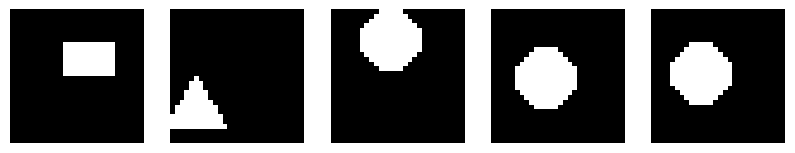

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import torch
from torch.utils.data import Dataset

class ShapesDataset(Dataset):
    def __init__(self, num_samples):
        self.num_samples = num_samples
        self.images = []
        self.generate_shapes()

    def generate_shapes(self):
        for _ in range(self.num_samples):
            img = Image.new('L', (28, 28), 0)
            draw = ImageDraw.Draw(img)
            shape_type = np.random.choice(['circle', 'triangle', 'rectangle'])

            x, y = np.random.randint(5, 20), np.random.randint(5, 20)

            if shape_type == 'circle':
                r = 6
                draw.ellipse([x-r, y-r, x+r, y+r], outline=255, fill=255)
            elif shape_type == 'triangle':
                points = [(x, y), (x+6, y+10), (x-6, y+10)]
                draw.polygon(points, outline=255, fill=255)
            elif shape_type == 'rectangle':
                w, h = 10, 6
                draw.rectangle([x, y, x+w, y+h], outline=255, fill=255)

            img_np = np.array(img, dtype=np.float32) / 255.0
            self.images.append(img_np)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return torch.tensor(self.images[idx]).unsqueeze(0)


dataset = ShapesDataset(num_samples=50000)

fig, axs = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    axs[i].imshow(dataset[i].squeeze(), cmap='gray')
    axs[i].axis('off')
plt.show()


***2.*** ***Variational Autoencoder Architecture and Training with Tuned Parameters***

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

class VAE(nn.Module):
    def __init__(self, latent_dim=3):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)

        # Decoder
        self.fc_decoder = nn.Linear(latent_dim, 128 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x).view(x.size(0), -1)
        mu = self.fc_mu(x)

        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)

        x = self.fc_decoder(z).view(-1, 128, 4, 4)
        x = self.decoder(x)
        return x, mu, logvar

latent_dim = 3
model = VAE(latent_dim=latent_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1, Train Loss: 76.7447, Val Loss: 35.5348
Epoch 2, Train Loss: 32.3182, Val Loss: 30.2860
Epoch 3, Train Loss: 26.6420, Val Loss: 25.0533
Epoch 4, Train Loss: 22.1398, Val Loss: 20.3187
Epoch 5, Train Loss: 18.9713, Val Loss: 19.9675
Epoch 6, Train Loss: 17.6398, Val Loss: 16.4750
Epoch 7, Train Loss: 16.2732, Val Loss: 17.1114
Epoch 8, Train Loss: 15.9525, Val Loss: 15.6179
Epoch 9, Train Loss: 15.2099, Val Loss: 14.8521
Epoch 10, Train Loss: 15.0595, Val Loss: 15.0007
Epoch 11, Train Loss: 14.6440, Val Loss: 14.8281
Epoch 12, Train Loss: 14.6360, Val Loss: 15.0571
Epoch 13, Train Loss: 14.3170, Val Loss: 15.2316
Epoch 14, Train Loss: 14.2587, Val Loss: 13.8008
Epoch 15, Train Loss: 13.8688, Val Loss: 13.2363
Epoch 16, Train Loss: 14.0457, Val Loss: 13.1747
Epoch 18, Train Loss: 13.6376, Val Loss: 13.9873
Epoch 19, Train Loss: 13.5631, Val Loss: 13.6075
Epoch 20, Train Loss: 13.3784, Val Loss: 13.0523
Epoch 21, Train Loss: 13.3716, Val Loss: 13.1538
Epoch 22, Train Loss: 13.5251

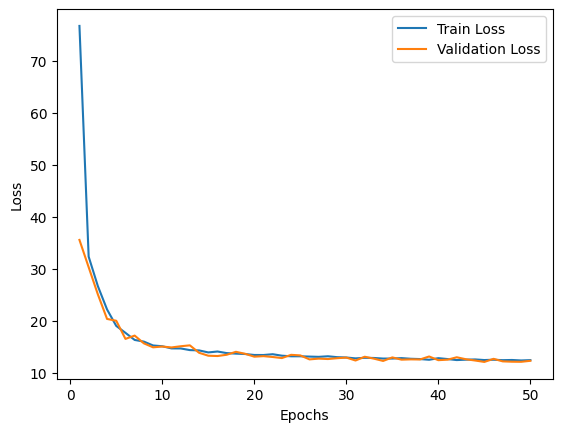

In [ ]:
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def loss_function(recon_x, x, mu, logvar):
    beta = 1
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + (beta * KLD)

epochs = 50
train_losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for data in train_loader:
        #data = data[0].unsqueeze(1)
        #data = data.to(torch.float32)  # Ensure the data type is correct
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in test_loader:
            #data = data[0].unsqueeze(1)
            #data = data.to(torch.float32)
            recon_batch, mu, logvar = model(data)
            val_loss += loss_function(recon_batch, data, mu, logvar).item()

    val_loss /= len(test_loader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

***3.*** ***Original Vs Reconstructed Images for VAE trained model***

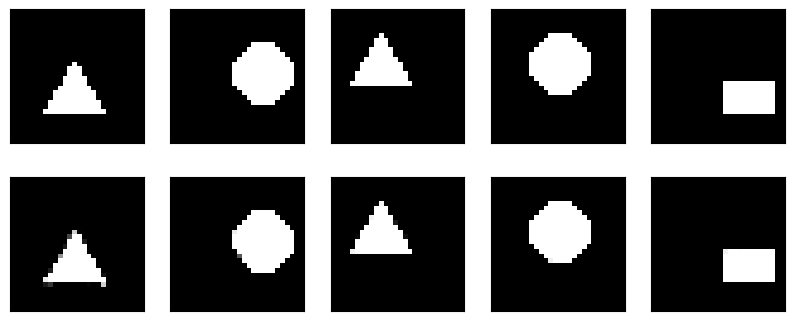

In [ ]:
import matplotlib.pyplot as plt

def show_images(original, reconstructed, n=10):

    plt.figure(figsize=(10, 4))
    for i in range(n):
        # Display original image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].cpu().numpy().reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstructed image
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].cpu().numpy().reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

model.eval()
with torch.no_grad():
    for data in test_loader:
        recon_batch, mu, logvar = model(data)
        show_images(data, recon_batch, n=5)
        break

***4.*** ***Newly Generated Images for VAE trained model***

In [ ]:
import torch
import matplotlib.pyplot as plt

def generate_images(model, num_images=5, latent_dim=3):
    model.eval()
    images = []

    with torch.no_grad():
        for _ in range(num_images):
            z = torch.randn(1, latent_dim)
            decoded_image = model.fc_decoder(z).view(-1, 128, 4, 4)
            decoded_image = model.decoder(decoded_image)
            images.append(decoded_image)

    images = torch.cat(images)
    show_images(images)

def show_images(images):
    if images.ndim == 4:
        num_images = images.shape[0]
        fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
        for i in range(num_images):
            axes[i].imshow(images[i].squeeze(0).detach().cpu().numpy(), cmap='gray')
            axes[i].axis('off')
        plt.show()
    else:
        print("Invalid shape for image data:", images.shape)

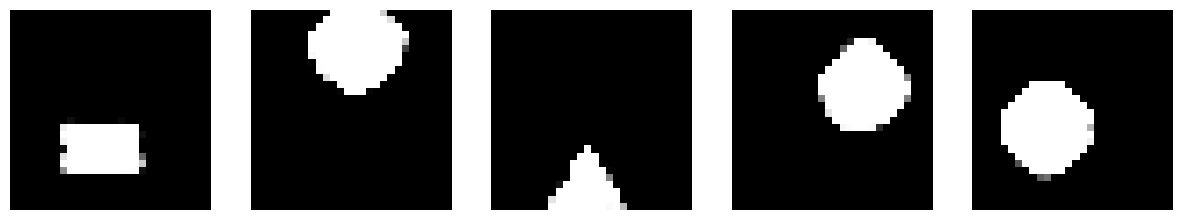

In [ ]:
generate_images(model, num_images=5, latent_dim=latent_dim)

***5.*** ***Modified Basic Autoencoder Architecture and Training with Tuned Parameters***

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

class ModifiedAutoencoder(nn.Module):
    def __init__(self, latent_dim=3, noise_std=0.1):
        super(ModifiedAutoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.noise_std = noise_std

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU()
        )
        self.fc_encoder = nn.Linear(128 * 4 * 4, latent_dim)

        # Decoder
        self.fc_decoder = nn.Linear(latent_dim, 128 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):

        x = self.encoder(x).view(x.size(0), -1)
        z = self.fc_encoder(x)

        z = z + self.noise_std * torch.randn_like(z)

        x = self.fc_decoder(z).view(-1, 128, 4, 4)
        x = self.decoder(x)
        return x

Epoch 1, Train Loss: 31.6210, Val Loss: 10.2916
Epoch 2, Train Loss: 8.0404, Val Loss: 6.5512
Epoch 3, Train Loss: 5.7708, Val Loss: 5.2256
Epoch 4, Train Loss: 4.4357, Val Loss: 3.6654
Epoch 5, Train Loss: 3.4257, Val Loss: 3.4399
Epoch 6, Train Loss: 2.7322, Val Loss: 2.2964
Epoch 7, Train Loss: 2.3081, Val Loss: 2.2226
Epoch 8, Train Loss: 2.0220, Val Loss: 1.6756
Epoch 9, Train Loss: 1.9133, Val Loss: 1.7865
Epoch 10, Train Loss: 1.6663, Val Loss: 1.6902
Epoch 11, Train Loss: 1.5412, Val Loss: 1.3719
Epoch 12, Train Loss: 1.4752, Val Loss: 1.5149
Epoch 13, Train Loss: 1.4938, Val Loss: 1.5850
Epoch 14, Train Loss: 1.3453, Val Loss: 1.7642
Epoch 15, Train Loss: 1.3078, Val Loss: 1.0355
Epoch 16, Train Loss: 1.2533, Val Loss: 1.1274
Epoch 17, Train Loss: 1.2327, Val Loss: 1.1707
Epoch 18, Train Loss: 1.2558, Val Loss: 1.2657
Epoch 19, Train Loss: 1.2316, Val Loss: 1.1899
Epoch 20, Train Loss: 1.1435, Val Loss: 2.3909
Epoch 21, Train Loss: 1.0609, Val Loss: 1.1971
Epoch 22, Train Loss

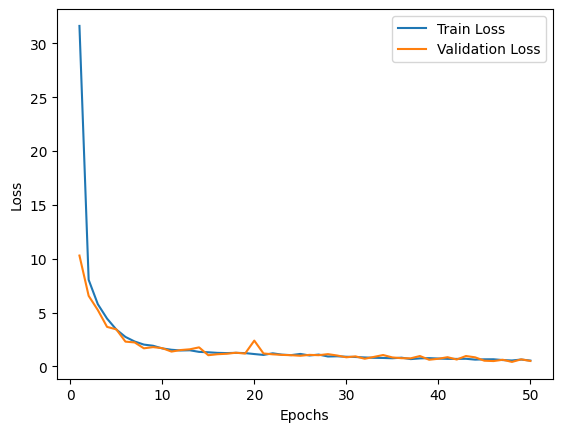

In [ ]:
latent_dim = 3
noise_std = 0.1
model_1 = ModifiedAutoencoder(latent_dim=latent_dim, noise_std=noise_std)
optimizer = optim.Adam(model_1.parameters(), lr=0.001)

def loss_function(recon_x, x):
    MSE = F.mse_loss(recon_x, x, reduction='sum')
    return MSE

epochs = 50
train_losses, val_losses = [], []

dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
test_size = dataset_size - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for epoch in range(epochs):
    model_1.train()
    train_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        recon_batch = model_1(data)
        loss = loss_function(recon_batch, data)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    model_1.eval()
    val_loss = 0
    with torch.no_grad():
        for data in test_loader:
            recon_batch = model_1(data)
            val_loss += loss_function(recon_batch, data).item()

    val_loss /= len(test_loader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

***6.*** ***Original Vs Reconstructed Images for Modified Autoencoder trained model***

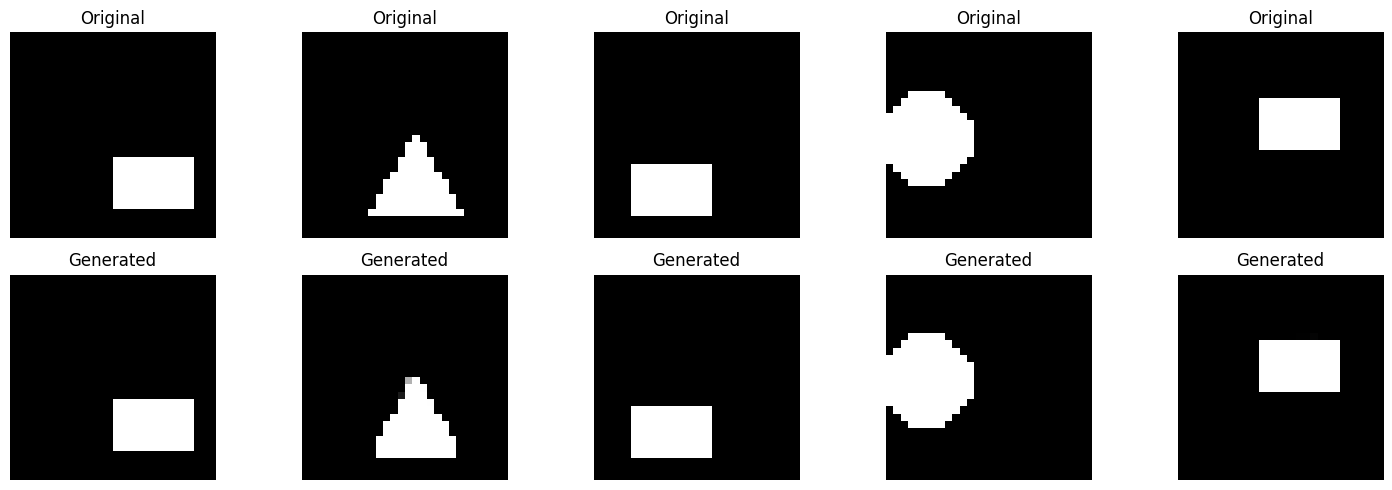

In [ ]:
import matplotlib.pyplot as plt

def show_images(original, generated, num_images=5):
    original = original.squeeze().detach().cpu().numpy()
    generated = generated.squeeze().detach().cpu().numpy()

    fig, axes = plt.subplots(2, num_images, figsize=(15, 5))
    for i in range(num_images):
        axes[0, i].imshow(original[i], cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title('Original')

        axes[1, i].imshow(generated[i], cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title('Generated')

    plt.tight_layout()
    plt.show()

model_1.eval()
with torch.no_grad():
    for batch_idx, data in enumerate(test_loader):
        recon_batch = model_1(data)
        show_images(data, recon_batch, num_images=5)
        break

***7.*** ***Newly Generated Images for Modified Autoencoder trained model***

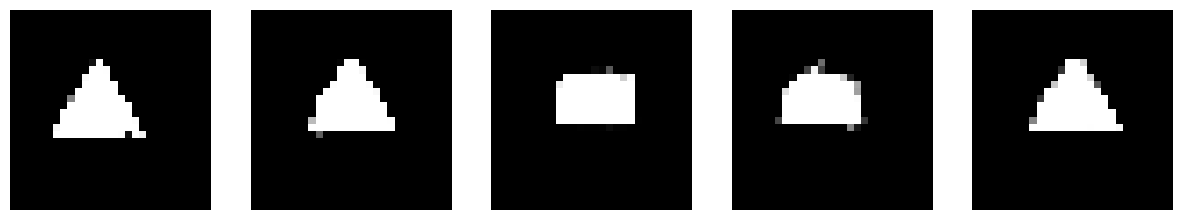

In [ ]:
generate_images(model_1, num_images=5, latent_dim=latent_dim)

***8.*** ***Calculation of Information Passing through Latent Layer for Modified Autoencoder***

In [ ]:
import torch

def estimate_information(latent_vars, noise_variance):
    latent_vars_var = torch.var(latent_vars, dim=0)
    info_per_dim = 0.5 * torch.log2(1 + latent_vars_var / noise_variance)
    total_info = torch.sum(info_per_dim).item()
    return total_info

latent_dim = 3
noise_variance = 1.0  # Variance of Gaussian noise
model_1.eval()

total_information = 0.0
num_batches = 0

with torch.no_grad():
    for batch in train_loader:
        batch = batch.to(torch.float32)
        x = model_1.encoder(batch).view(batch.size(0), -1)
        latent_vars = model_1.fc_encoder(x)

        batch_info = estimate_information(latent_vars, noise_variance)
        total_information += batch_info
        num_batches += 1

average_information = total_information / num_batches if num_batches > 0 else 0
print(f"Average information passing through latent layer: {average_information:.4f} bits")


Average information passing through latent layer: 11.8005 bits


***9.*** ***MSE and SSIM for standard VAE***

In [ ]:
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim

def calculate_mse(original, reconstructed):
    return F.mse_loss(reconstructed, original).item()

def calculate_ssim(original, reconstructed):
    original_np = original.squeeze().detach().cpu().numpy()
    reconstructed_np = reconstructed.squeeze().detach().cpu().numpy()
    return ssim(original_np, reconstructed_np, data_range=1.0)

In [ ]:
def evaluate_reconstruction(model, data_loader):
    model.eval()
    total_mse, total_ssim = 0, 0
    with torch.no_grad():
        for batch in data_loader:
            reconstructed, mu, logvar = model(batch)
            for i in range(batch.size(0)):
                original_image = batch[i]
                reconstructed_image = reconstructed[i]

                total_mse += calculate_mse(original_image, reconstructed_image)
                total_ssim += calculate_ssim(original_image, reconstructed_image)

    avg_mse = total_mse / len(data_loader.dataset)
    avg_ssim = total_ssim / len(data_loader.dataset)
    return avg_mse, avg_ssim

mse_standard, ssim_standard = evaluate_reconstruction(model, test_loader)
print(f'MSE (Standard VAE): {mse_standard}, SSIM (Standard VAE): {ssim_standard}')

MSE (Standard VAE): 0.0005070894757936557, SSIM (Standard VAE): 0.9931687362552518


***10.*** ***MSE and SSIM for Modified Autoencoder***

In [ ]:
def evaluate_reconstruction(model, data_loader):
    model.eval()
    total_mse, total_ssim = 0, 0
    with torch.no_grad():
        for batch in data_loader:
            reconstructed = model(batch)
            for i in range(batch.size(0)):
                original_image = batch[i]
                reconstructed_image = reconstructed[i]
                # Calculate MSE and SSIM
                total_mse += calculate_mse(original_image, reconstructed_image)
                total_ssim += calculate_ssim(original_image, reconstructed_image)

    avg_mse = total_mse / len(data_loader.dataset)
    avg_ssim = total_ssim / len(data_loader.dataset)
    return avg_mse, avg_ssim

mse_modified, ssim_modified = evaluate_reconstruction(model_1, test_loader)
print(f'MSE (Modified VAE): {mse_modified}, SSIM (Modified VAE): {ssim_modified}')

MSE (Modified VAE): 0.0006487916824318488, SSIM (Modified VAE): 0.9934291301161832


***11.*** ***Interpolation for standard VAE between two latent vectors***

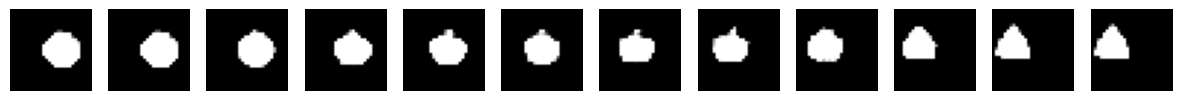

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

def interpolate_images(model, z1, z2, steps=10):
    model.eval()
    interpolations = []
    with torch.no_grad():
        for i in range(steps):
            alpha = i / (steps - 1)
            z = (1 - alpha) * z1 + alpha * z2
            interpolated_image = model.fc_decoder(z).view(-1, 128, 4, 4)
            interpolated_image = model.decoder(interpolated_image)
            interpolations.append(interpolated_image)

    return torch.cat(interpolations)

def show_images(original_images):
    # Ensure the shape is correct for visualization
    if original_images.ndim == 4:  # (N, C, H, W)
        num_images = original_images.shape[0]
        fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
        for i in range(num_images):
            axes[i].imshow(original_images[i].squeeze(0).detach().cpu().numpy(), cmap='gray')
            axes[i].axis('off')
        plt.show()
    else:
        print("Invalid shape for image data:", original_images.shape)

latent_dim = 3
z1 = torch.randn(1, latent_dim)
z2 = torch.randn(1, latent_dim)

original_image_1_s = model.fc_decoder(z1).view(-1, 128, 4, 4)
original_image_1_s = model.decoder(original_image_1_s)

original_image_2_s = model.fc_decoder(z2).view(-1, 128, 4, 4)
original_image_2_s = model.decoder(original_image_2_s)

interpolations_standard = interpolate_images(model, z1, z2)
all_images_standard = torch.cat([original_image_1_s, interpolations_standard, original_image_2_s])

show_images(all_images_standard)

***12.*** ***Interpolation for Modified Autoencoder between two latent vectors***

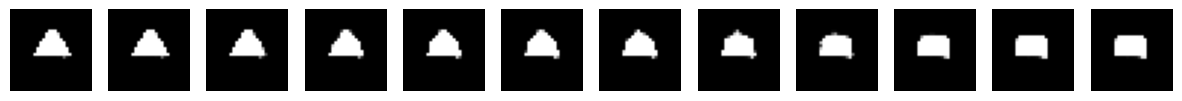

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

def interpolate_images(model, z1, z2, steps=10):
    model.eval()
    interpolations = []
    with torch.no_grad():
        for i in range(steps):
            alpha = i / (steps - 1)
            z = (1 - alpha) * z1 + alpha * z2
            interpolated_image = model.fc_decoder(z).view(-1, 128, 4, 4)
            interpolated_image = model.decoder(interpolated_image)
            interpolations.append(interpolated_image)

    return torch.cat(interpolations)

latent_dim = 3
z1 = torch.randn(1, latent_dim)
z2 = torch.randn(1, latent_dim)

original_image_1_m = model_1.fc_decoder(z1).view(-1, 128, 4, 4)
original_image_1_m = model_1.decoder(original_image_1_m)

original_image_2_m = model_1.fc_decoder(z2).view(-1, 128, 4, 4)
original_image_2_m = model_1.decoder(original_image_2_m)

interpolations_modified = interpolate_images(model_1, z1, z2)
all_images_modified = torch.cat([original_image_1_m, interpolations_modified, original_image_2_m])

show_images(all_images_modified)

***13.*** ***t-SNE visualization for newly generated images from standard VAE trained model***

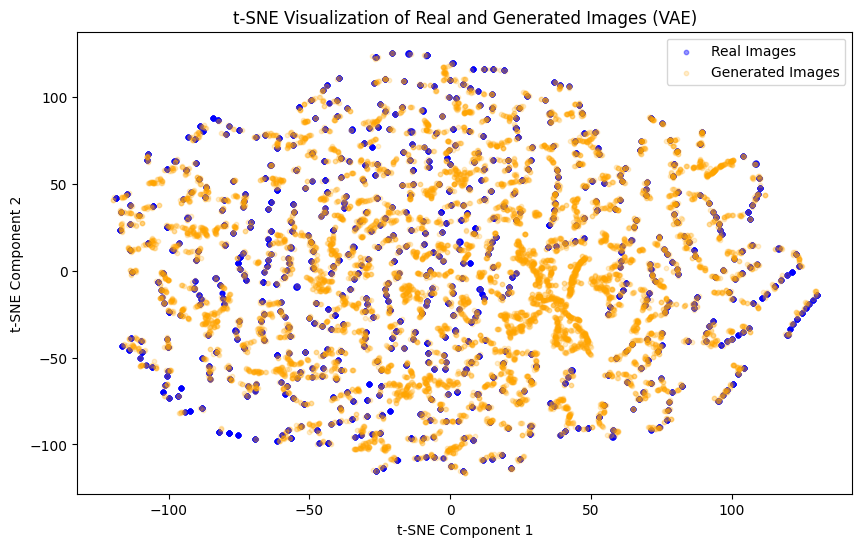

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader, TensorDataset

def get_latent_representations(model, data_loader):
    model.eval()
    latent_vectors = []
    with torch.no_grad():
        for data in data_loader:
            data = data.to(torch.float32)
            _, mu, _ = model(data)
            latent_vectors.append(mu)

    return torch.cat(latent_vectors).cpu().numpy()

real_latent_representations = get_latent_representations(model, test_loader)

latent_dim = 3
num_generated = 10000
random_latents = torch.randn(num_generated, latent_dim)

with torch.no_grad():
    generated_images = model.decoder(model.fc_decoder(random_latents).view(-1, 128, 4, 4))

generated_latent_representations = get_latent_representations(model, DataLoader(generated_images, batch_size=64, shuffle=False))
combined_latent_representations = np.concatenate((real_latent_representations, generated_latent_representations))

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(combined_latent_representations)

tsne_results_real = tsne_results[:len(real_latent_representations)]
tsne_results_generated = tsne_results[len(real_latent_representations):]

def plot_tsne(tsne_results_real, tsne_results_generated, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(tsne_results_real[:, 0], tsne_results_real[:, 1], label='Real Images', alpha=0.4, c='blue', s=10)  # Adjust s for point size
    plt.scatter(tsne_results_generated[:, 0], tsne_results_generated[:, 1], label='Generated Images', alpha=0.2, c='orange', s=10)  # Adjust s for point size
    plt.title(title)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.legend()
    plt.show()

plot_tsne(tsne_results_real, tsne_results_generated, "t-SNE Visualization of Real and Generated Images (Standard VAE)")

***14.*** ***t-SNE visualization for newly generated images from Modified Autoencoder trained model***

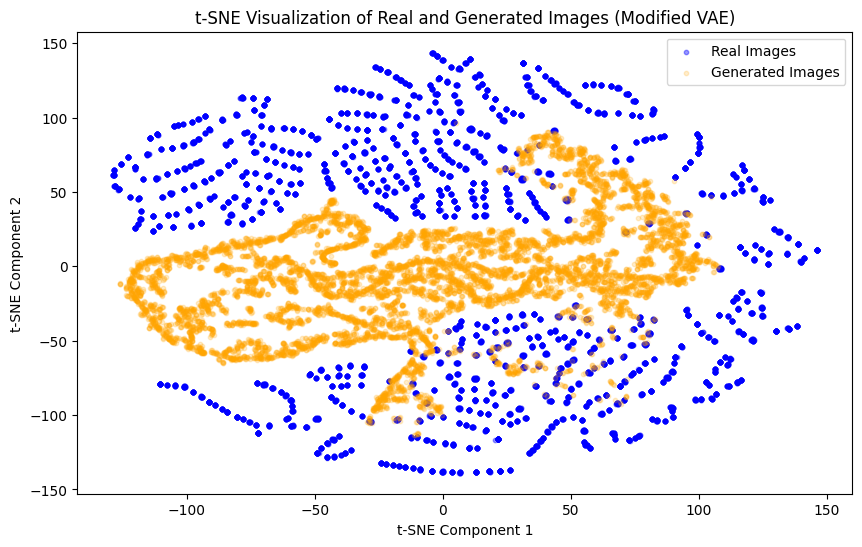

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader, TensorDataset

def get_latent_representations(model, data_loader):
    model.eval()
    latent_vectors = []
    with torch.no_grad():
        for data in data_loader:
            data = data.to(torch.float32)
            x = model.encoder(data).view(data.size(0), -1)
            z = model.fc_encoder(x)
            latent_vectors.append(z)

    return torch.cat(latent_vectors).cpu().numpy()

real_latent_representations = get_latent_representations(model_1, test_loader)

latent_dim = 3
num_generated = 10000
random_latents = torch.randn(num_generated, latent_dim)

with torch.no_grad():
    generated_images = model_1.decoder(model.fc_decoder(random_latents).view(-1, 128, 4, 4))

generated_latent_representations = get_latent_representations(model_1, DataLoader(generated_images, batch_size=64, shuffle=False))
combined_latent_representations = np.concatenate((real_latent_representations, generated_latent_representations))

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(combined_latent_representations)

tsne_results_real = tsne_results[:len(real_latent_representations)]
tsne_results_generated = tsne_results[len(real_latent_representations):]

plot_tsne(tsne_results_real, tsne_results_generated, "t-SNE Visualization of Real and Generated Images (Modified VAE)")